In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지 설치
! pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.1


#### < 데이터셋 준비 >

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'C:\\Users\\user\\.keras\\datasets\\auto-mpg.data'

In [4]:
# Auto MPG 데이터셋 다운로드

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

# pandas를 사용하여 데이터를 읽어오기
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", 
                          comment='\t', sep=" ", skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()

In [7]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### < 데이터셋 정제하기 >

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
# 데이터가 누락된 행을 확인

In [9]:
# 누락된 행을삭제
dataset = dataset.dropna()

In [11]:
# "Origin" 열은 수치형이 아니고 범주형이므로 
# 원-핫 인코딩(one-hot encoding)으로 변환

# 기존 "Origin" 열을 제거
origin = dataset.pop('Origin')

In [12]:
# 원핫 인코딩 형태로 변경
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

In [13]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### < 훈련세트와 테스트세트로 분할 >

In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### < 데이터 조사하기 >

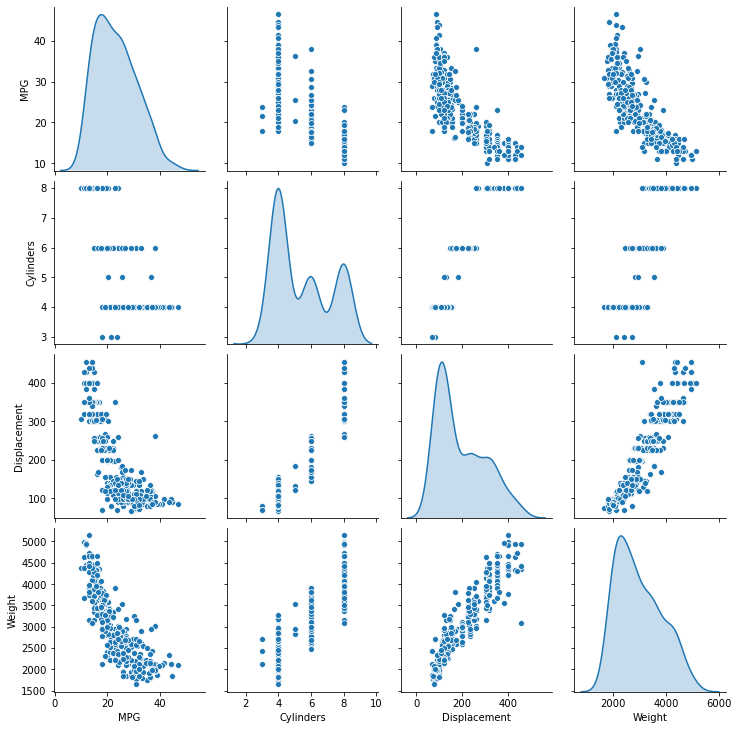

In [15]:
# 몇 개의 열을 선택한 후, 산점도 행렬을 만들어 분포 확인

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], 
             diag_kind="kde")

In [16]:
train_stats = train_dataset.describe()

In [17]:
train_stats.pop("MPG")
train_stats = train_stats.transpose()

In [18]:
# 전반적인 통계 확인
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### < 특성과 레이블 분리 >

In [19]:
# 특성에서 타깃 값 또는 "레이블"을 분리
# 이 레이블을 예측하기 위해 모델을 훈련시켜 볼 것 

In [20]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### < 데이터 정규화 >

In [21]:
# 특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됨

# 특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 
# 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어짐

In [22]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [23]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### < 모델 만들기 >

In [24]:
# 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델을 만들어 보기
# 출력 층은 하나의 연속적인 값을 반환

In [25]:
# 나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸기

In [26]:
def build_model():
    
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001) 

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

  return model

In [27]:
model = build_model()

#### < 모델 확인 >

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 훈련 세트에서 10 샘플을 하나의 배치로 만들어 model.predict 메서드를 호출

In [30]:
example_batch = normed_train_data[:10]

example_result = model.predict(example_batch)
example_result

array([[-0.03341874],
       [ 0.11452459],
       [-0.86689836],
       [-0.2085227 ],
       [ 0.30555502],
       [-0.21200924],
       [ 0.36149603],
       [-0.14072424],
       [-0.11007175],
       [ 0.66199994]], dtype=float32)

#### < 모델 훈련 >

In [31]:
# 이 모델을 1,000번의 에포크(epoch) 동안 훈련

In [32]:
class PrintDot(keras.callbacks.Callback):
    
  def on_epoch_end(self, epoch, logs):
    
    if epoch % 100 == 0: print('')
    print('.', end='')
    # 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시

In [33]:
EPOCHS = 1000

In [34]:
# 훈련 정확도와 검증 정확도는 history 객체에 기록

In [35]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [36]:
# history 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [39]:
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.447278,1.007574,2.447278,9.783725,2.322178,9.783725,995
996,2.300186,0.984602,2.300186,9.944397,2.369878,9.944397,996
997,2.400994,0.983379,2.400994,9.617108,2.350021,9.617108,997
998,2.222948,0.939039,2.222948,9.420017,2.343161,9.420017,998
999,2.566728,1.026891,2.566728,10.080156,2.412530,10.080156,999


In [40]:
import matplotlib.pyplot as plt

In [41]:
def plot_history(history):
    
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  ###########################################################
  
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
    
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  
  plt.ylim([0,5])
  plt.legend()
  
  ###########################################################
 
  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
    
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
  
  plt.ylim([0,20])
  plt.legend()
 
  ###########################################################

  plt.show()

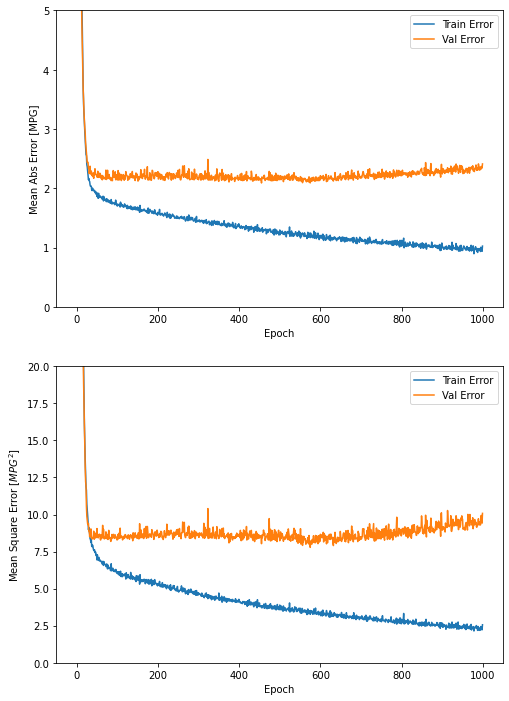

In [42]:
plot_history(history)

In [43]:
# 이 그래프를 보면, 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 X

In [44]:
# model.fit 메서드를 수정하여 
# 검증점수가 향상되지 않을 시에 
# 자동으로 훈련을 멈추도록 만들어 보기

In [45]:
# 에포크 마다 훈련상태 점검을 위해, EarlyStopping 콜백(callback)을 사용

In [46]:
# 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춤

In [47]:
model = build_model()

In [48]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [49]:
# 앞쪽에서 사용한 model.fit 메서드

# history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
#                     validation_split = 0.2, verbose=0, 
#                     callbacks=[PrintDot()])

In [50]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, PrintDot()])


....................................................................................................

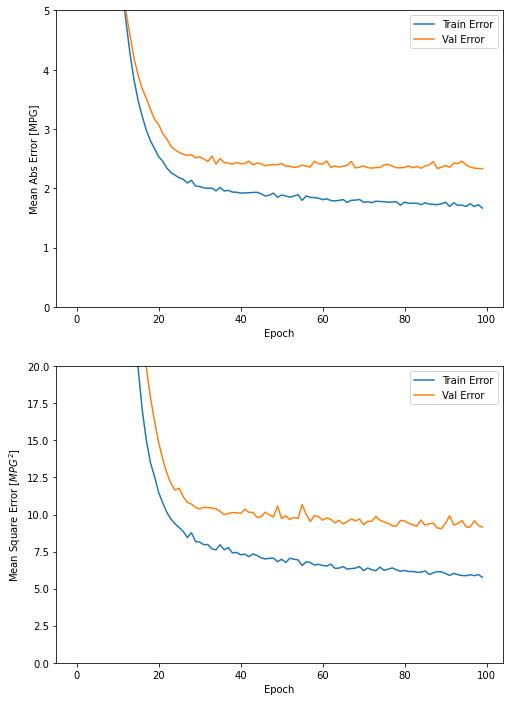

In [51]:
plot_history(history)

#### < 모델 성능 확인 >

In [52]:
# 모델을 훈련할 때 사용하지 않았던 테스트 세트에서 모델의 성능을 확인

In [53]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

3/3 - 0s - loss: 6.3922 - mae: 2.0162 - mse: 6.3922


In [54]:
print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

테스트 세트의 평균 절대 오차:  2.02 MPG


#### < 예측 >

In [55]:
# flatten() : 다차원 배열을 1차원으로 평평하게 해주는 함수

In [56]:
test_predictions = model.predict(normed_test_data).flatten()

In [59]:
# 그래프 출력

1.0

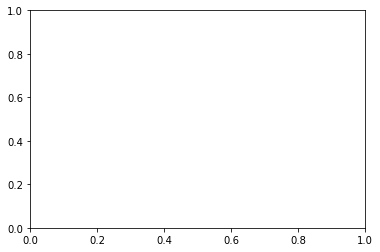

In [60]:
plt.xlim()[1]

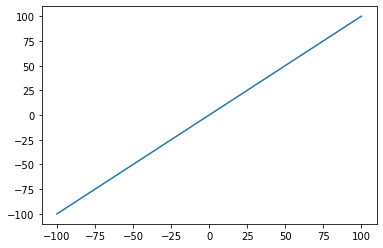

In [61]:
_ = plt.plot([-100, 100], [-100, 100])

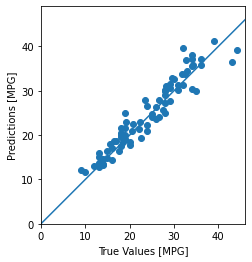

In [62]:
plt.scatter(test_labels, test_predictions)

plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

plt.axis('equal')
plt.axis('square')

plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

In [64]:
# 오차의 분포 파악

In [65]:
error = test_predictions - test_labels

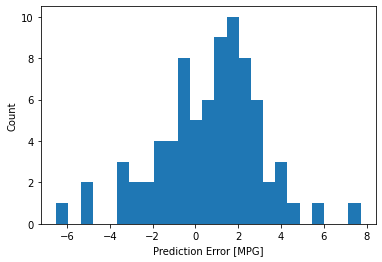

In [66]:
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [67]:
# 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수
# 분류 문제에서 사용하는 손실 함수와 다름

In [68]:
# 훈련 데이터가 많지 않다면 과대적합을 피하기 위해
# 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋음

In [69]:
# 조기 종료(Early stopping)는 과대적합을 방지하기 위한 좋은 방법